In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import os, sys, time
sys.path.append("..")
from all_funcs import util
from model import Generator, Discriminator, train_discriminator, train_generator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float64')
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

In [2]:
from numba import cuda
os.environ['CUDA_VISIBLE_DEVICES']="1"
print(tf.test.is_gpu_available())

True


In [3]:
df=pd.read_csv("../dataset/df_noOutliner_ana.csv",index_col=0)
df, imp_mode, imp_mean=util.FeatureArrange(df)

In [4]:
## reduce redundant features which can be assembled
dataset=df.drop(['NIHTotal','THD_ID','cortical_CT', 'subcortical_CT',
              'circulation_CT', 'CT_find', 'watershed_CT', 'Hemorrhagic_infarct_CT',
              'CT_left', 'CT_right',],axis=1)

In [5]:
sc = MinMaxScaler()
dataset.loc[:,dataset.columns] = sc.fit_transform(dataset.loc[:,dataset.columns])


In [6]:
## setting hyperparameter
latent_dim = dataset.shape[1]
epochs = 40000
batch_size= 128
buffer_size = 6000
# save_interval = 50
n_critic = 5
checkpoint_dir = './training_checkpoints'


In [7]:
generator = Generator(latent_dim)
discriminator = Discriminator()

In [8]:
## create Cross Entropy
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
gen_opt = tf.keras.optimizers.Adam(0.00001, 0.5)
disc_opt = tf.keras.optimizers.Adam(0.00001,)

In [10]:
# save checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_opt,
                                 discriminator_optimizer=disc_opt,
                                 generator=generator,
                                 discriminator=discriminator)

In [11]:
X_train, X_test = train_test_split(dataset, test_size=0.2,shuffle=True,
                                   stratify=dataset['elapsed_class'],
                                   random_state=None)

In [1]:
# separate to 0,1 dataset
data_1=X_train.loc[X_train['elapsed_class']==1]
data_0=X_train.loc[X_train['elapsed_class']==0]
## store losses
### generator losses
losses_gen = np.array([])
best_loss_gen = np.inf
### discriminator losses
losses_dis = np.array([])
best_loss_dis = np.inf

for epoch in range(epochs):
    start = time.time()
    disc_loss = 0
    gen_loss = 0

    # resample the dataset
    data1_shape_0 = data_1.sample(data_0.shape[0])
    df_same_shape = pd.concat([data1_shape_0, data_0]).to_numpy()

#     # slices to data and labels
#     df_same_ = df_same_shape.iloc[:, :-1].to_numpy()
#     org_label = df_same_shape.iloc[:, -1].to_numpy().reshape(-1, 1)

    # create batch dataset
    training_dataset = tf.data.Dataset.from_tensor_slices(df_same_shape)\
        .shuffle(buffer_size).batch(batch_size, drop_remainder=True)

    for data in training_dataset:
        for _ in range(n_critic): # 5*discriminator times, 1*generator times
            disc_loss += train_discriminator(data, generator,
                                             discriminator, disc_opt, latent_dim)
#         if disc_opt.iterations.numpy() % n_critic == 0: ### using samples
        gen_loss+= train_generator(data, generator,
                                    discriminator, gen_opt, batch_size, latent_dim)
    
    losses_gen= np.append(losses_gen, gen_loss / batch_size)
    losses_dis= np.append(losses_dis, disc_loss / (batch_size*n_critic))
    print('Time for epoch {} is {} sec - gen_loss = {}, disc_loss = {}'.format(epoch + 1, time.time() - start,
                                                                               gen_loss / batch_size,
                                                                               disc_loss / (batch_size*n_critic)))
    # save best discriminator or generator
    if abs(best_loss_gen) > abs((gen_loss / batch_size)):
        best_loss_gen = (gen_loss / batch_size)
        generator.save_weights(checkpoint_prefix+"gen", save_format='tf')
        
    if abs(best_loss_dis) > abs((disc_loss / (batch_size*n_critic))):
        best_loss_dis = (disc_loss / (batch_size*n_critic))
        discriminator.save_weights(checkpoint_prefix+"dis", save_format='tf')
    

In [ ]:
## Record the 40000 gen_loss = 1.0660838669396047, disc_loss = -0.002908965222095772

## show the training results

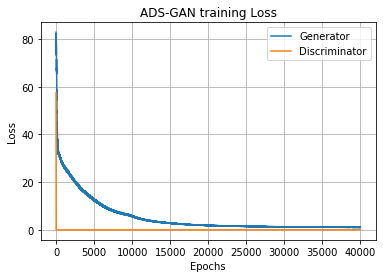

In [23]:
plt.title("ADS-GAN training Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.grid()
plt.plot(losses_gen, label='Generator')
plt.plot(losses_dis, label='Discriminator')
plt.legend(loc='best')
plt.savefig("./ADS-GAN_LOSS.png",dpi=300)
plt.show()

In [30]:
## create matrix 0 row*latent_dim columns
arr=np.empty((0,latent_dim))
noise = tf.random.normal([128, latent_dim])

## batch testing data
testing_dataset = tf.data.Dataset.from_tensor_slices(X_test.to_numpy())\
        .shuffle(buffer_size).batch(batch_size, drop_remainder=True)

## generate dataset
for data in testing_dataset:
    gen_=generator(noise, data).numpy()
    arr=np.append(arr,gen_,axis=0)
arr.shape

(896, 63)

In [31]:
output_dataset = pd.DataFrame(np.round(sc.inverse_transform(arr)), columns=[
    'BT_NM', 'HR_NM', 'RR_NM', 'HB_NM', 'HCT_NM', 'PLATELET_NM', 'WBC_NM',
    'PTT1_NM', 'PTT2_NM', 'PTINR_NM', 'ER_NM', 'BUN_NM', 'CRE_NM', 'BMI',
    'age', 'PPD', 'THDA_FL', 'THDH_FL', 'THDI_FL', 'THDAM_FL', 'THDV_FL',
    'THDE_FL', 'THDM_FL', 'THDR_FL', 'THDP_FL', 'THDOO_FL', 'Gender',
    'cortical_ACA_ctr', 'cortical_MCA_ctr', 'subcortical_ACA_ctr',
    'subcortical_MCA_ctr', 'PCA_cortex_ctr', 'thalamus_ctr',
    'brainstem_ctr', 'cerebellum_ctr', 'Watershed_ctr',
    'Hemorrhagic_infarct_ctr', 'cortical_ACA_ctl', 'cortical_MCA_ctl',
    'subcortical_ACA_ctl', 'subcortical_MCA_ctl', 'PCA_cortex_ctl',
    'thalamus_ctl', 'brainstem_ctl', 'cerebellum_ctl', 'Watershed_ctl',
    'Hemorrhagic_infarct_ctl', 'NIHS_1a_in', 'NIHS_1b_in', 'NIHS_1c_in',
    'NIHS_2_in', 'NIHS_3_in', 'NIHS_4_in', 'NIHS_5aL_in', 'NIHS_5bR_in',
    'NIHS_6aL_in', 'NIHS_6bR_in', 'NIHS_7_in', 'NIHS_8_in', 'NIHS_9_in',
    'NIHS_10_in', 'NIHS_11_in','elapsed_class'
])
output_dataset

,BT_NM,HR_NM,RR_NM,HB_NM,HCT_NM,PLATELET_NM,WBC_NM,PTT1_NM,PTT2_NM,PTINR_NM,ER_NM,BUN_NM,CRE_NM,BMI,age,PPD,THDA_FL,THDH_FL,THDI_FL,THDAM_FL,THDV_FL,THDE_FL,THDM_FL,THDR_FL,THDP_FL,THDOO_FL,Gender,cortical_ACA_ctr,cortical_MCA_ctr,subcortical_ACA_ctr,subcortical_MCA_ctr,PCA_cortex_ctr,thalamus_ctr,brainstem_ctr,cerebellum_ctr,Watershed_ctr,Hemorrhagic_infarct_ctr,cortical_ACA_ctl,cortical_MCA_ctl,subcortical_ACA_ctl,subcortical_MCA_ctl,PCA_cortex_ctl,thalamus_ctl,brainstem_ctl,cerebellum_ctl,Watershed_ctl,Hemorrhagic_infarct_ctl,NIHS_1a_in,NIHS_1b_in,NIHS_1c_in,NIHS_2_in,NIHS_3_in,NIHS_4_in,NIHS_5aL_in,NIHS_5bR_in,NIHS_6aL_in,NIHS_6bR_in,NIHS_7_in,NIHS_8_in,NIHS_9_in,NIHS_10_in,NIHS_11_in,elapsed_class
0,36.0,78.0,18.0,15.0,45.0,145.0,6.0,27.0,29.0,1.0,122.0,17.0,1.0,27.0,56.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,37.0,83.0,21.0,15.0,45.0,225.0,11.0,28.0,29.0,1.0,170.0,13.0,1.0,27.0,56.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,37.0,98.0,20.0,16.0,42.0,226.0,11.0,31.0,47.0,1.0,129.0,15.0,1.0,20.0,71.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
3,36.0,85.0,18.0,13.0,37.0,412.0,12.0,27.0,28.0,1.0,124.0,22.0,2.0,22.0,77.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,1.0
4,36.0,70.0,18.0,12.0,29.0,123.0,7.0,20.0,24.0,1.0,80.0,31.0,2.0,22.0,67.0,79.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,0.0,2.0,3.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,37.0,76.0,18.0,13.0,37.0,185.0,8.0,26.0,28.0,1.0,155.0,15.0,1.0,27.0,69.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
892,36.0,93.0,23.0,15.0,44.0,163.0,10.0,35.0,30.0,1.0,146.0,21.0,1.0,23.0,81.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,4.0,0.0,3.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0
893,36.0,65.0,15.0,15.0,43.0,155.0,6.0,19.0,22.0,1.0,124.0,22.0,1.0,25.0,64.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,0.0,4.0,0.0,3.0,0.0,1.0,3.0,2.0,1.0,1.0
894,36.0,81.0,22.0,15.0,45.0,235.0,12.0,30.0,30.0,1.0,185.0,19.0,1.0,27.0,69.0,80.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [32]:
output_dataset.to_csv("../dataset/output_dataset/ADS-GAN_models.csv",encoding='utf_8_sig')

In [34]:
X_TEST_dataset = pd.DataFrame(np.round(sc.inverse_transform(X_test)), columns=[
    'BT_NM', 'HR_NM', 'RR_NM', 'HB_NM', 'HCT_NM', 'PLATELET_NM', 'WBC_NM',
    'PTT1_NM', 'PTT2_NM', 'PTINR_NM', 'ER_NM', 'BUN_NM', 'CRE_NM', 'BMI',
    'age', 'PPD', 'THDA_FL', 'THDH_FL', 'THDI_FL', 'THDAM_FL', 'THDV_FL',
    'THDE_FL', 'THDM_FL', 'THDR_FL', 'THDP_FL', 'THDOO_FL', 'Gender',
    'cortical_ACA_ctr', 'cortical_MCA_ctr', 'subcortical_ACA_ctr',
    'subcortical_MCA_ctr', 'PCA_cortex_ctr', 'thalamus_ctr',
    'brainstem_ctr', 'cerebellum_ctr', 'Watershed_ctr',
    'Hemorrhagic_infarct_ctr', 'cortical_ACA_ctl', 'cortical_MCA_ctl',
    'subcortical_ACA_ctl', 'subcortical_MCA_ctl', 'PCA_cortex_ctl',
    'thalamus_ctl', 'brainstem_ctl', 'cerebellum_ctl', 'Watershed_ctl',
    'Hemorrhagic_infarct_ctl', 'NIHS_1a_in', 'NIHS_1b_in', 'NIHS_1c_in',
    'NIHS_2_in', 'NIHS_3_in', 'NIHS_4_in', 'NIHS_5aL_in', 'NIHS_5bR_in',
    'NIHS_6aL_in', 'NIHS_6bR_in', 'NIHS_7_in', 'NIHS_8_in', 'NIHS_9_in',
    'NIHS_10_in', 'NIHS_11_in','elapsed_class'
])
X_TEST_dataset.to_csv("../dataset/output_dataset/ADS-GAN_XTEST.csv",encoding='utf_8_sig')